# Part I: Encoding images into StyleGAN's latent space

![alt text](https://miro.medium.com/max/1280/0*eeFaGLx96mlbQcrK.gif)

1. Upgrade tqdm:

In [2]:
!pip install --upgrade tqdm

     |████████████████████████████████| 71kB 3.8MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


2. Restart the Python kernel to load the updated version:

In [0]:
import os 
os.kill(os.getpid(), 9)

In [1]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 483, done.
remote: Total 483 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (483/483), 12.75 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [2]:
cd stylegan-encoder

/content/stylegan-encoder


In [3]:
ls

adaptive.py                            Play_with_latent_directions.ipynb
align_images.py                        pretrained_example.py*
config.py*                             README.md*
dataset_tool.py*                       requirements.txt
dnnlib/                                robust_loss/
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


In [0]:
rm -rf aligned_images raw_images

In [0]:
mkdir aligned_images raw_images

## // take images using your webcam

In [0]:
# from IPython.display import HTML, Audio
# from google.colab.output import eval_js
# from base64 import b64decode
# import numpy as np
# import io
# from PIL import Image
# from datetime import datetime

# VIDEO_HTML = """
# <video autoplay
#  width=%d height=%d style='cursor: pointer;'></video>
# <script>

# var video = document.querySelector('video')

# navigator.mediaDevices.getUserMedia({ video: true })
#   .then(stream=> video.srcObject = stream)
  
# var data = new Promise(resolve=>{
#   video.onclick = ()=>{
#     var canvas = document.createElement('canvas')
#     var [w,h] = [video.offsetWidth, video.offsetHeight]
#     canvas.width = w
#     canvas.height = h
#     canvas.getContext('2d')
#           .drawImage(video, 0, 0, w, h)
#     video.srcObject.getVideoTracks()[0].stop()
#     video.replaceWith(canvas)
#     resolve(canvas.toDataURL('image/jpeg', %f))
#   }
# })
# </script>
# """

# def take_photo(quality=1.0, size=(800,600)):
#   display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
#   data = eval_js("data")
#   binary = b64decode(data.split(',')[1])
#   f = io.BytesIO(binary)
#   img = np.asarray(Image.open(f))
  
#   timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
#   filename = 'raw_images/photo_%s.jpeg' %timestampStr
#   Image.fromarray(img).save(filename)
#   print('Image captured and saved to %s' %filename)

In [0]:
# img = take_photo() # click the image to capture a frame!

## Let's check the contents of our image folder before we start:
#### (You can always manually delete images by right clicking on them in the file tab)

Found 4 images in raw_images
['gan1.jpg', 'gan2.jpg', 'gan3.jpg', 'gan4.jpg']


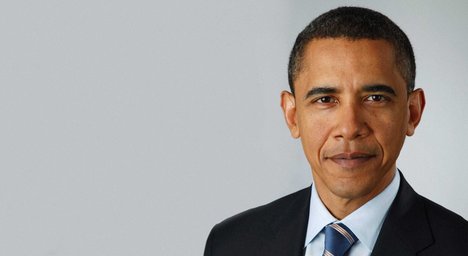

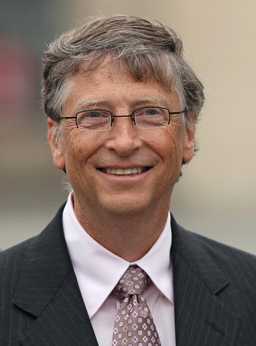

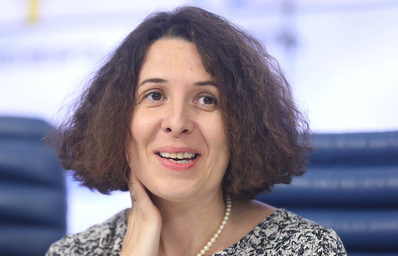

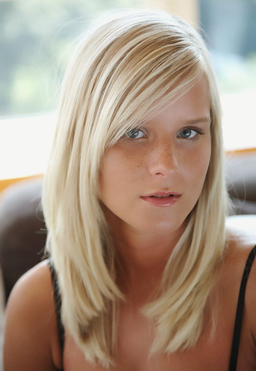

In [6]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

## Make sure we're using the right TensorFlow version (1.15):

In [7]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# II. Auto-Align faces:
### This script wil:


1.   Look for faces in the images
2.   Crop out the faces from the images
3.   Align the faces (center the nose and make the eyes horizontal)
4.   Rescale the resulting images and save them in "aligned_images" folder

### The cell below takes about a minute to run



In [8]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 4s 0us/step
Aligning gan2.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/gan2_01.png
Aligning gan3.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/gan3_01.png
Aligning gan1.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/gan1_01.png
Aligning gan4.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/gan4_01.png


## Let's take a look at our aligned images:

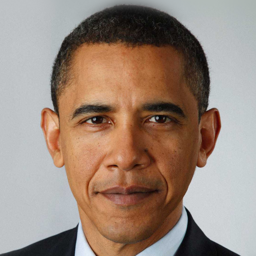

'img 0: gan1_01.png'

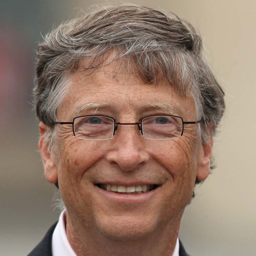

'img 1: gan2_01.png'

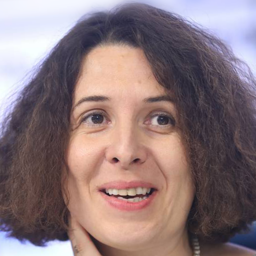

'img 2: gan3_01.png'

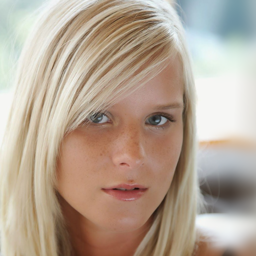

'img 3: gan4_01.png'

In [9]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

# Encoding faces into StyleGAN latent space:

![title](https://raw.githubusercontent.com/pbaylies/stylegan-encoder/master/mona_example.jpg)

## First, let's download a pretrained resnet encoder:

In [10]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:02, 138MB/s]


# III. The actual encoding process:
> #### Highly recommended: play with the encoding params: they have a huge effect on the latent representations & images!
> #### Extra encoding options: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py

#### Note: This script will also download:


*   The pretrained StyleGAN network from NVIDIA trained on faces
*   A pretrained VGG-16 network, trained on ImageNet

#### After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!
#### Note that by default, we're optimizing w vectors, not z-vectors!


In [11]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 4 images ready for encoding!
Recommended batch_size for the encode_images process: 4


#### Important: to avoid issues, set the batch_size argument lower than or equal to the number of aligned_images (see previous cell)
> Keep batch_size<8 or the GPU might run out of memory

### Depending on the settings, the encoding process might take a few minutes...

## Fast version:

In [0]:
# !python encode_images.py --model_url="https://www.dropbox.com/s/h0hagkpk0q9h4h1/karras2019stylegan-ffhq-1024x1024.pkl?dl=1" --optimizer=lbfgs --batch_size=4 --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
# print("\n************ Latent code optimization finished! ***************")

## Slow version:

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
!python encode_images.py --model_url="https://www.dropbox.com/s/h0hagkpk0q9h4h1/karras2019stylegan-ffhq-1024x1024.pkl?dl=1" --optimizer=adam --batch_size 4 --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 2s 0us/step
  0% 0/1 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Saving mask masks/gan3_01.png
Saving mask masks/gan2_01.png
Saving mask masks/gan4_01.png
Saving mask masks/gan1_01.png
Loading ResNet Model:

  0% 0/400 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:292: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

gan3

## Showtime!
### Let's load the StyleGAN network into memory:

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")







Loading StyleGAN model from cache/668f470067c87c774e3176713aa2d543_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let's plot some random StyleGAN samples:

In [18]:
plot_imgs(averaged_generator_network, 3, 3)

Output hidden; open in https://colab.research.google.com to view.

# Let's take a look at the results of our encoding:
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 500)
> 2. Decrease the L1 penalty (to eg 0.15)
> 3. Try a lower initial learning rate (eg 0.02) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
> 5. You can find a bunch of good presets on the repo documentation: https://github.com/pbaylies/stylegan-encoder

In [1]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

NameError: ignored

## Let's compare our encoded samples with the original ones:

**Note: when you optimized with the setting --face_mask=True, the hair will be copied from the source images. If you don't want this, optimize without that setting!**

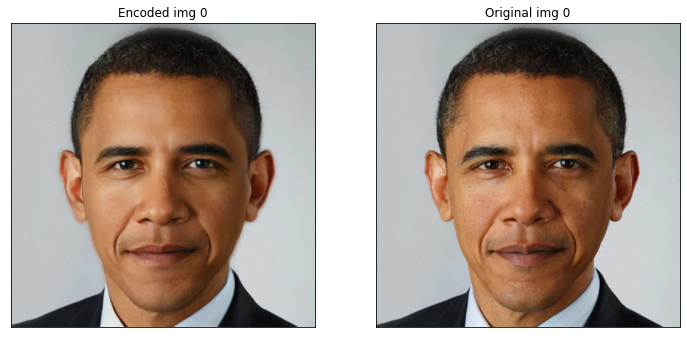

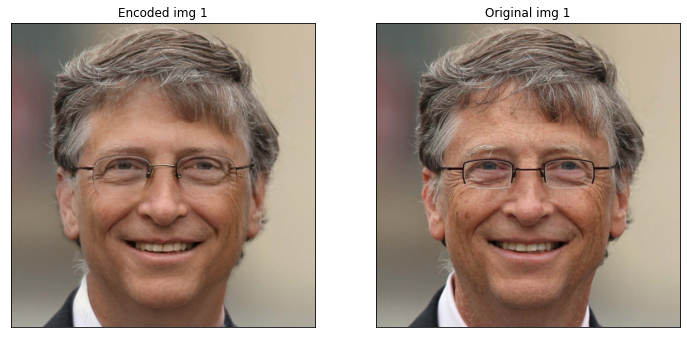

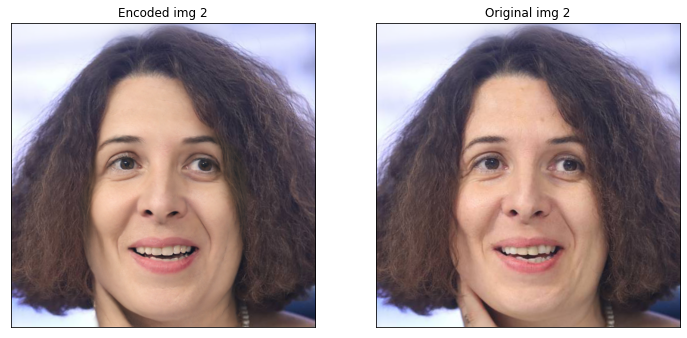

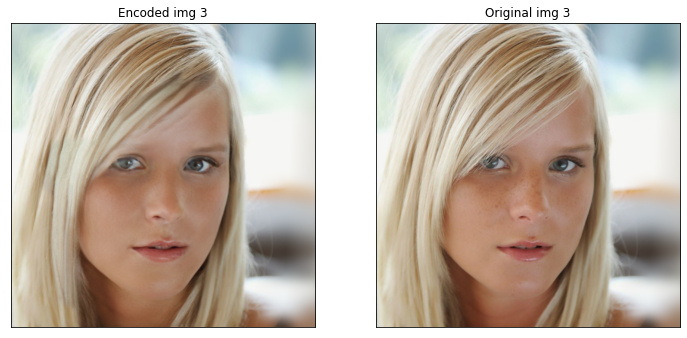

In [18]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

## Save these latent vectors to disk:

In [0]:
good_images = [0,1,2,3]  #Change these numbers to pick out latents that worked well (see the image plots)

In [20]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

4 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!
